In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import join as p_join

import seaborn as sns


##################################
## GLOBAL SETTINGS ###############
##################################
plt.rcParams["figure.figsize"] = (12,8)

In [2]:
### Install CPU torch
# ! pip3 install torch==1.10.2+cpu torchvision==0.11.3+cpu torchaudio==0.10.2+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
    
### Inctall GPU torch (CUDA 11.3)
# ! pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
###############################
##### IMPORT DL Depensies #####
###############################
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

from tqdm import tqdm


def seed_all(seed=42):

    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("[ Using Seed : ", seed, " ]")

####################################
#####   SEED ALL EXPERIMENTS   #####
####################################
seed_all()    


#################################
####### GLOBAL CONFIG ###########
#################################
CONFIG = {'ephs': 15,
          'train_batch_size': 1024,
          'test_batch_size': 64,
          'cpu_workers': 2,
          'save_ckpts': True,
          'ckpt_save_folder': 'mlp_ckpts_L_10_6'}

[ Using Seed :  42  ]


In [4]:
import sys
sys.path.append("../..") # Adds higher directory to python modules path.
from utils import utils
from utils import dl_models

In [5]:
data_path = p_join('..', '..', 'data_2')

### Create dataset

In [6]:
#################################
#### MAKE TEST TRAIN SPLIT   ####
#################################
def create_dataloaders(CONFIG, X, Y):
    from sklearn.model_selection import train_test_split

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)


    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

    train_dataloader = DataLoader(train_dataset,
                                  shuffle=True,
                                  num_workers=CONFIG['cpu_workers'],
                                  batch_size=CONFIG['train_batch_size'],
                                  drop_last=True)

    test_dataloader = DataLoader(test_dataset,
                                 shuffle=False,
                                 num_workers=CONFIG['cpu_workers'],
                                 batch_size=CONFIG['test_batch_size'],
                                 drop_last=False)

    return train_dataloader, test_dataloader

In [11]:
def helper(num):
    n_needed = 'both'
    if num % 2 == 0:
        n_needed = 'n+1'
        N = f'N2={num - 1}'
    else:
        n_needed = 'n'
        N = f'N2={num}'
    return N, n_needed

def make_merged_dataset(nums, n_feat=16, normalize=True):
    seed_all()
    X_merged, Y_merged = [], []
    for num in nums:
        N, n = helper(num)
        FOLDERS = [p_join(os.path.abspath(data_path), item) for item in os.listdir(data_path) if N in item]
        X, Y = utils.create_dataset(FOLDERS, feature_nums=n_feat, n=n, verbose=False)
        X = utils.normalize_data(X)
        X_merged.append(X)
        Y_merged.append(Y)

    X, Y = np.concatenate(X_merged, axis=0), np.concatenate(Y_merged, axis=0)
    indexes_for_shuffle = np.random.permutation(np.arange(X.shape[0]))
    X = X[indexes_for_shuffle]
    Y = Y[indexes_for_shuffle]
    
    print(f'Dataset for nums:{nums} was created')
    if normalize:
        X = utils.normalize_data(X)
    return X, Y

In [ ]:
def multy_cross_test(model, ckpts_paths, dataloader_creator_func):

    data = {p: [] for p in ckpts_paths}

    for ckpt_path in ckpts_paths:
        print(ckpt_path)
        ckpt = torch.load(p_join('..', 'dl', ckpt_path, 'model_best.ckpt'))
        model.load_state_dict(ckpt)
        for ckpt_path_test in ckpts_paths:
            loader = dataloader_creator_func(ckpt_path_test)
            acc = utils.test_model(model, loader, device='cpu')
            data[ckpt_path].append(acc)
            
    df = pd.DataFrame.from_dict(data, orient='index', columns=[ckpt_path.split('_')[4] for ckpt_path in ckpts_paths])
    return df

In [ ]:
def plot_matshow(df, x_labels, y_labels, cmap_name='YlGn'):
    fig, ax = plt.subplots()
    cax = ax.matshow(df, cmap=plt.get_cmap(cmap_name))
    fig.colorbar(cax)
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_ylabel('Train')
    ax.set_xlabel('Test')
    return fig, ax

### Run training

In [12]:
n_feat = 16
for num in [[i] for i in range(21, 29)]:
    ckpt = f'mlp_ckpts_really_N_{num[0]}_16_features'
    CONFIG['ckpt_save_folder'] = ckpt
    X, Y = make_merged_dataset(num, n_feat=n_feat)
    net = dl_models.MlpNeLight(n_feat)
    utils.count_params(net)
    train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
    optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 5e-3))
    utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.86it/s]


Dataset for nums:[21] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.29it/s]


Epoch: 1/15, 	 total train loss: 0.24850163431537728


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 204.58it/s]


Epoch: 1/15, 	 total score test: 99.75003124609424, [best score: 99.75003124609424]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.37it/s]


Epoch: 2/15, 	 total train loss: 0.007530710945326475


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 231.16it/s]


Epoch: 2/15, 	 total score test: 99.87501562304712, [best score: 99.87501562304712]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.52it/s]


Epoch: 3/15, 	 total train loss: 0.0037223075050860643


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 293.75it/s]


Epoch: 3/15, 	 total score test: 99.93750781152356, [best score: 99.93750781152356]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.93it/s]


Epoch: 4/15, 	 total train loss: 0.00260567148929582


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 283.89it/s]


Epoch: 4/15, 	 total score test: 99.97500312460943, [best score: 99.97500312460943]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.78it/s]


Epoch: 5/15, 	 total train loss: 0.0010752320428559137


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 295.45it/s]


Epoch: 5/15, 	 total score test: 99.98750156230471, [best score: 99.98750156230471]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.24it/s]


Epoch: 6/15, 	 total train loss: 0.001270758247213258


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 276.81it/s]


Epoch: 6/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.65it/s]


Epoch: 7/15, 	 total train loss: 0.0006003083572948292


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 258.03it/s]


Epoch: 7/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.58it/s]


Epoch: 8/15, 	 total train loss: 0.0013589390277517059


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 271.39it/s]


Epoch: 8/15, 	 total score test: 99.96250468691413, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.51it/s]


Epoch: 9/15, 	 total train loss: 0.0016447233389161767


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 287.57it/s]


Epoch: 9/15, 	 total score test: 99.92500937382827, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.52it/s]


Epoch: 10/15, 	 total train loss: 0.001480446055328714


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 269.99it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.85it/s]


Epoch: 11/15, 	 total train loss: 0.0003317267429308906


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 257.12it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.59it/s]


Epoch: 12/15, 	 total train loss: 0.000204669289110649


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 268.77it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.58it/s]


Epoch: 13/15, 	 total train loss: 0.00015650225114152437


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 282.96it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.16it/s]


Epoch: 14/15, 	 total train loss: 0.00013219770874955782


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 215.66it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 18.55it/s]


Epoch: 15/15, 	 total train loss: 0.00011211555641737857


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 285.79it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.86it/s]


Dataset for nums:[22] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.69it/s]


Epoch: 1/15, 	 total train loss: 0.20304126800188133


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 218.11it/s]


Epoch: 1/15, 	 total score test: 99.83741870935468, [best score: 99.83741870935468]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.42it/s]


Epoch: 2/15, 	 total train loss: 0.006622534436774591


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 238.69it/s]


Epoch: 2/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.52it/s]


Epoch: 3/15, 	 total train loss: 0.0020981072560854017


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 285.53it/s]


Epoch: 3/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.23it/s]


Epoch: 4/15, 	 total train loss: 0.0013210740289650857


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 268.97it/s]


Epoch: 4/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.28it/s]


Epoch: 5/15, 	 total train loss: 0.0009779837020041963


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 271.33it/s]


Epoch: 5/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.18it/s]


Epoch: 6/15, 	 total train loss: 0.0005564286566955308


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 255.17it/s]


Epoch: 6/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.19it/s]


Epoch: 7/15, 	 total train loss: 0.00032178288599806685


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 261.04it/s]


Epoch: 7/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.46it/s]


Epoch: 8/15, 	 total train loss: 0.00026006660764030514


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 254.36it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.94it/s]


Epoch: 9/15, 	 total train loss: 0.00020695207762577


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 262.34it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.37it/s]


Epoch: 10/15, 	 total train loss: 0.00017593753188022322


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 222.56it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.26it/s]


Epoch: 11/15, 	 total train loss: 0.00014562840430787014


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 242.95it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.70it/s]


Epoch: 12/15, 	 total train loss: 0.00013124841573317685


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 271.54it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.62it/s]


Epoch: 13/15, 	 total train loss: 0.0001163092658257923


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 278.33it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.18it/s]


Epoch: 14/15, 	 total train loss: 0.00011400354372697973


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 278.97it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.03it/s]


Epoch: 15/15, 	 total train loss: 9.64611965408098e-05


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 266.22it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.80it/s]


Dataset for nums:[23] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.30it/s]


Epoch: 1/15, 	 total train loss: 0.24684983149411216


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 199.89it/s]


Epoch: 1/15, 	 total score test: 99.93741394417324, [best score: 99.93741394417324]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.34it/s]


Epoch: 2/15, 	 total train loss: 0.004282369976863265


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 226.93it/s]


Epoch: 2/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.28it/s]


Epoch: 3/15, 	 total train loss: 0.0013379718349765867


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 256.80it/s]


Epoch: 3/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.83it/s]


Epoch: 4/15, 	 total train loss: 0.003418738859885883


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 286.19it/s]


Epoch: 4/15, 	 total score test: 99.84979346601577, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.71it/s]


Epoch: 5/15, 	 total train loss: 0.0030559402507459445


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 280.94it/s]


Epoch: 5/15, 	 total score test: 99.92489673300788, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.84it/s]


Epoch: 6/15, 	 total train loss: 0.0019383615262115435


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 289.89it/s]


Epoch: 6/15, 	 total score test: 99.91237952184254, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.43it/s]


Epoch: 7/15, 	 total train loss: 0.0017223662129723497


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 271.45it/s]


Epoch: 7/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.25it/s]


Epoch: 8/15, 	 total train loss: 0.0004880788431863391


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 282.40it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.22it/s]


Epoch: 9/15, 	 total train loss: 0.0002602261947392816


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 210.53it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.59it/s]


Epoch: 10/15, 	 total train loss: 0.00022119946867948579


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 274.22it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.03it/s]


Epoch: 11/15, 	 total train loss: 0.0001776992562114291


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 268.62it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.82it/s]


Epoch: 12/15, 	 total train loss: 0.00015969321060354912


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 256.85it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.26it/s]


Epoch: 13/15, 	 total train loss: 0.00014528700182469742


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 284.89it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.60it/s]


Epoch: 14/15, 	 total train loss: 0.00012436831973665845


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 282.59it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.14it/s]


Epoch: 15/15, 	 total train loss: 0.00011561266235789404


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 264.72it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.87it/s]


Dataset for nums:[24] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.55it/s]


Epoch: 1/15, 	 total train loss: 0.2002685278083288


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 214.68it/s]


Epoch: 1/15, 	 total score test: 99.88761238761239, [best score: 99.88761238761239]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 16.43it/s]


Epoch: 2/15, 	 total train loss: 0.005196005646740237


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 159.90it/s]


Epoch: 2/15, 	 total score test: 99.96253746253747, [best score: 99.96253746253747]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.05it/s]


Epoch: 3/15, 	 total train loss: 0.003320806723598751


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 265.05it/s]


Epoch: 3/15, 	 total score test: 99.87512487512487, [best score: 99.96253746253747]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.50it/s]


Epoch: 4/15, 	 total train loss: 0.003033083176330453


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 268.54it/s]


Epoch: 4/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.42it/s]


Epoch: 5/15, 	 total train loss: 0.0010624953710864629


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 267.34it/s]


Epoch: 5/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.65it/s]


Epoch: 6/15, 	 total train loss: 0.0005064365057830489


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 267.42it/s]


Epoch: 6/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.25it/s]


Epoch: 7/15, 	 total train loss: 0.00037225090613168094


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 272.60it/s]


Epoch: 7/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.92it/s]


Epoch: 8/15, 	 total train loss: 0.0002304822029996543


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 248.30it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.64it/s]


Epoch: 9/15, 	 total train loss: 0.0001811152413269625


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 264.77it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.55it/s]


Epoch: 10/15, 	 total train loss: 0.00015453485356110538


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 280.57it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.54it/s]


Epoch: 11/15, 	 total train loss: 0.00013422470956650232


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 246.04it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.94it/s]


Epoch: 12/15, 	 total train loss: 0.00011977124273882157


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 222.84it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.17it/s]


Epoch: 13/15, 	 total train loss: 0.00011260638970153166


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 268.56it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.31it/s]


Epoch: 14/15, 	 total train loss: 0.0001016821312781934


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 223.96it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.47it/s]


Epoch: 15/15, 	 total train loss: 8.868407448678608e-05


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 283.01it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.06it/s]


Dataset for nums:[25] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.59it/s]


Epoch: 1/15, 	 total train loss: 0.2532422325363563


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 170.54it/s]


Epoch: 1/15, 	 total score test: 99.80067272953781, [best score: 99.80067272953781]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.72it/s]


Epoch: 2/15, 	 total train loss: 0.006295413154387666


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 272.82it/s]


Epoch: 2/15, 	 total score test: 99.87542045596113, [best score: 99.87542045596113]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 18.82it/s]


Epoch: 3/15, 	 total train loss: 0.0026968658653899065


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 215.07it/s]


Epoch: 3/15, 	 total score test: 99.97508409119223, [best score: 99.97508409119223]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.73it/s]


Epoch: 4/15, 	 total train loss: 0.0011634286305296324


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 274.17it/s]


Epoch: 4/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.30it/s]


Epoch: 5/15, 	 total train loss: 0.0006502311688006646


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 253.97it/s]


Epoch: 5/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.56it/s]


Epoch: 6/15, 	 total train loss: 0.000537427720583735


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 232.15it/s]


Epoch: 6/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.78it/s]


Epoch: 7/15, 	 total train loss: 0.0004515069350975776


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 262.30it/s]


Epoch: 7/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.97it/s]


Epoch: 8/15, 	 total train loss: 0.0003467738955101419


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 281.69it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.62it/s]


Epoch: 9/15, 	 total train loss: 0.0003119336540675572


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 247.89it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.56it/s]


Epoch: 10/15, 	 total train loss: 0.0002477773415457998


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 267.99it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.95it/s]


Epoch: 11/15, 	 total train loss: 0.00021089016151944957


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 262.17it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.93it/s]


Epoch: 12/15, 	 total train loss: 0.00018356749909974996


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 277.15it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.59it/s]


Epoch: 13/15, 	 total train loss: 0.0001606617142604063


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 279.49it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.31it/s]


Epoch: 14/15, 	 total train loss: 0.00014437887218645624


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 237.16it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 18.10it/s]


Epoch: 15/15, 	 total train loss: 0.00012911684062865173


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 213.28it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 18.05it/s]


Dataset for nums:[26] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 15.62it/s]


Epoch: 1/15, 	 total train loss: 0.20350559884982725


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 186.71it/s]


Epoch: 1/15, 	 total score test: 99.77415307402761, [best score: 99.77415307402761]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 18.53it/s]


Epoch: 2/15, 	 total train loss: 0.005060892371881393


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 248.96it/s]


Epoch: 2/15, 	 total score test: 99.98745294855709, [best score: 99.98745294855709]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.30it/s]


Epoch: 3/15, 	 total train loss: 0.0019907455801242784


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 243.11it/s]


Epoch: 3/15, 	 total score test: 99.98745294855709, [best score: 99.98745294855709]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.03it/s]


Epoch: 4/15, 	 total train loss: 0.0011830035514468627


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 252.21it/s]


Epoch: 4/15, 	 total score test: 99.96235884567126, [best score: 99.98745294855709]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.11it/s]


Epoch: 5/15, 	 total train loss: 0.001468396405764525


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 264.36it/s]


Epoch: 5/15, 	 total score test: 99.96235884567126, [best score: 99.98745294855709]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.44it/s]


Epoch: 6/15, 	 total train loss: 0.0012947423787291854


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 246.21it/s]


Epoch: 6/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.48it/s]


Epoch: 7/15, 	 total train loss: 0.0006466293604218311


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 281.73it/s]


Epoch: 7/15, 	 total score test: 99.98745294855709, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.64it/s]


Epoch: 8/15, 	 total train loss: 0.0002649614898179988


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 282.32it/s]


Epoch: 8/15, 	 total score test: 99.98745294855709, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.68it/s]


Epoch: 9/15, 	 total train loss: 0.00020113911934106822


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 285.74it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.48it/s]


Epoch: 10/15, 	 total train loss: 0.0001667808532910121


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 258.05it/s]


Epoch: 10/15, 	 total score test: 99.98745294855709, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.51it/s]


Epoch: 11/15, 	 total train loss: 0.0001419116151444013


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 290.33it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.32it/s]


Epoch: 12/15, 	 total train loss: 0.0001233213660006802


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 284.01it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.60it/s]


Epoch: 13/15, 	 total train loss: 0.00012123351987083293


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 267.91it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.98it/s]


Epoch: 14/15, 	 total train loss: 0.00010479613950836563


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 281.18it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.71it/s]


Epoch: 15/15, 	 total train loss: 8.99827629778414e-05


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 276.92it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.36it/s]


Dataset for nums:[27] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.86it/s]


Epoch: 1/15, 	 total train loss: 0.24500994925056735


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 216.80it/s]


Epoch: 1/15, 	 total score test: 99.92454728370221, [best score: 99.92454728370221]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 18.92it/s]


Epoch: 2/15, 	 total train loss: 0.004882054354604934


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 280.63it/s]


Epoch: 2/15, 	 total score test: 99.98742454728371, [best score: 99.98742454728371]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.67it/s]


Epoch: 3/15, 	 total train loss: 0.0035896608080234257


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 282.29it/s]


Epoch: 3/15, 	 total score test: 99.98742454728371, [best score: 99.98742454728371]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.60it/s]


Epoch: 4/15, 	 total train loss: 0.0026933231631353976


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 288.12it/s]


Epoch: 4/15, 	 total score test: 99.96227364185111, [best score: 99.98742454728371]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.68it/s]


Epoch: 5/15, 	 total train loss: 0.002311269084231988


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 281.27it/s]


Epoch: 5/15, 	 total score test: 99.98742454728371, [best score: 99.98742454728371]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.42it/s]


Epoch: 6/15, 	 total train loss: 0.0007753031367751499


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 268.86it/s]


Epoch: 6/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.81it/s]


Epoch: 7/15, 	 total train loss: 0.0004104258691621644


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 286.56it/s]


Epoch: 7/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.30it/s]


Epoch: 8/15, 	 total train loss: 0.0003376783955196339


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 265.82it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.64it/s]


Epoch: 9/15, 	 total train loss: 0.0002619866206641159


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 259.27it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 23.15it/s]


Epoch: 10/15, 	 total train loss: 0.00022277593492500244


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 278.15it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.00it/s]


Epoch: 11/15, 	 total train loss: 0.00020114694733262782


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 283.02it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.55it/s]


Epoch: 12/15, 	 total train loss: 0.00017623635499002113


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 288.51it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.30it/s]


Epoch: 13/15, 	 total train loss: 0.00015359431281760936


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 284.28it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.45it/s]


Epoch: 14/15, 	 total train loss: 0.0001380183143004204


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 266.95it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.86it/s]


Epoch: 15/15, 	 total train loss: 0.00012673453931065818


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 285.68it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.91it/s]


Dataset for nums:[28] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.00it/s]


Epoch: 1/15, 	 total train loss: 0.20135441819025623


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 231.39it/s]


Epoch: 1/15, 	 total score test: 99.88811536548981, [best score: 99.88811536548981]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.91it/s]


Epoch: 2/15, 	 total train loss: 0.005217309139909283


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 285.63it/s]


Epoch: 2/15, 	 total score test: 99.96270512182994, [best score: 99.96270512182994]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.66it/s]


Epoch: 3/15, 	 total train loss: 0.0018672454790512642


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 279.60it/s]


Epoch: 3/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.00it/s]


Epoch: 4/15, 	 total train loss: 0.0008622844658431507


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 278.65it/s]


Epoch: 4/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.75it/s]


Epoch: 5/15, 	 total train loss: 0.0005798722061538888


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 294.01it/s]


Epoch: 5/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.44it/s]


Epoch: 6/15, 	 total train loss: 0.000400901744855688


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 283.76it/s]


Epoch: 6/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.50it/s]


Epoch: 7/15, 	 total train loss: 0.00030863179915374326


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 281.48it/s]


Epoch: 7/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.11it/s]


Epoch: 8/15, 	 total train loss: 0.00024288632172805768


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 281.18it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.38it/s]


Epoch: 9/15, 	 total train loss: 0.00021159014572584702


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 271.69it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.62it/s]


Epoch: 10/15, 	 total train loss: 0.00018559376598380867


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 290.23it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 21.04it/s]


Epoch: 11/15, 	 total train loss: 0.00016311325147868165


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 217.29it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.08it/s]


Epoch: 12/15, 	 total train loss: 0.00013767402091499178


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 253.19it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 22.09it/s]


Epoch: 13/15, 	 total train loss: 0.00012076395913966061


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 241.82it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 20.70it/s]


Epoch: 14/15, 	 total train loss: 0.00010648093748679986


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 271.37it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 19.86it/s]


Epoch: 15/15, 	 total train loss: 9.424824078920327e-05


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 233.37it/s]

Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]



### Run testing

In [33]:
def create_test_dataloader_for_each(ckpt_path):
    num = int(ckpt_path.split('_')[4])
    n_feat = int(ckpt_path.split('_')[5])
    X, Y = make_merged_dataset([num], n_feat=n_feat)
    _, test_dataloader = create_dataloaders(CONFIG, X, Y)
    return test_dataloader


model = dl_models.MlpNeLight(in_features=16)
ckpts_paths = ['mlp_ckpts_really_N_21_16_features', 'mlp_ckpts_really_N_22_16_features',
               'mlp_ckpts_really_N_23_16_features', 'mlp_ckpts_really_N_24_16_features',
               'mlp_ckpts_really_N_25_16_features', 'mlp_ckpts_really_N_26_16_features',
               'mlp_ckpts_really_N_27_16_features', 'mlp_ckpts_really_N_28_16_features',]
df = multy_cross_test(model, ckpts_paths, create_test_dataloader_for_each)

mlp_ckpts_really_N_21_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.28it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 279.72it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.37it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 301.86it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.97it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 255.27it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.07it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 278.69it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.10it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 293.65it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.28it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 272.98it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.43it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 288.28it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.47it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 253.89it/s]


mlp_ckpts_really_N_22_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.24it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 237.62it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.08it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 298.07it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.32it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 241.68it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.07it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 291.20it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.53it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 282.80it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.57it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 321.41it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.91it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 274.17it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 18.43it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 248.80it/s]


mlp_ckpts_really_N_23_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 25.09it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 294.70it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.44it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 287.35it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.40it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 275.45it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.28it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 279.74it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.15it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 303.53it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.95it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 300.17it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.58it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 211.89it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.94it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 233.30it/s]


mlp_ckpts_really_N_24_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.37it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 261.79it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.68it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 286.59it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.43it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 293.31it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.44it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 269.77it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.20it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 267.77it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 18.74it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 289.32it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.78it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 238.45it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.78it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 237.23it/s]


mlp_ckpts_really_N_25_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.18it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 233.31it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.35it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 218.24it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.44it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 247.20it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.04it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 286.56it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.71it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 282.27it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.69it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 307.10it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.87it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 274.23it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.31it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 258.17it/s]


mlp_ckpts_really_N_26_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.38it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 278.02it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.60it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 310.07it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.52it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 317.27it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.53it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 278.40it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.13it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 310.20it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.11it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 301.33it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.39it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 319.84it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.94it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 246.08it/s]


mlp_ckpts_really_N_27_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.85it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 261.23it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.07it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 289.59it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.52it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 233.52it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.62it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 215.29it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.08it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 241.94it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.63it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 276.16it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.65it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 304.92it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.92it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 297.67it/s]


mlp_ckpts_really_N_28_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.94it/s]


Dataset for nums:[21] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 299.37it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.25it/s]


Dataset for nums:[22] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 260.70it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.27it/s]


Dataset for nums:[23] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 290.62it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.15it/s]


Dataset for nums:[24] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 257.12it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.16it/s]


Dataset for nums:[25] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 235.43it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.14it/s]


Dataset for nums:[26] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 254.46it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.08it/s]


Dataset for nums:[27] was created


100%|████████████████████████████████████████| 125/125 [00:00<00:00, 299.04it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.20it/s]


Dataset for nums:[28] was created


100%|████████████████████████████████████████| 126/126 [00:00<00:00, 271.49it/s]


/tmp/ipykernel_23688/1073259438.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels)
/tmp/ipykernel_23688/1073259438.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


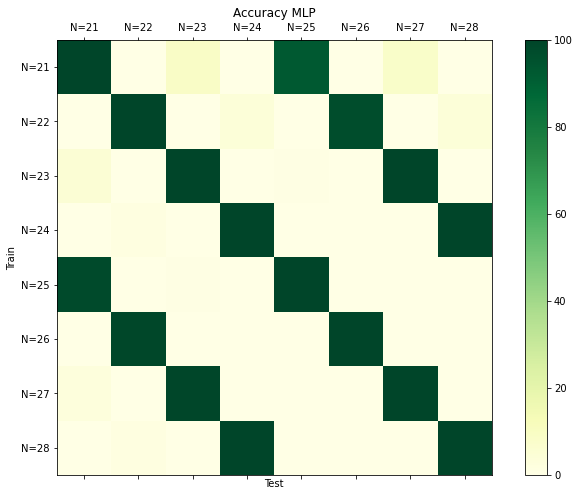

In [34]:
ticks = [f'N={21+i}' for i in range(8)]
fig_mlp, ax_mlp = plot_matshow(df, [' '] + ticks, [' '] + ticks)
ax_mlp.set_title('Accuracy MLP')
pass

### Try 22-23, 24-25, 26-27 data

In [40]:
n_feat = 16
for num in [[i, i+1] for i in range(22, 27, 2)]:
    ckpt = f'mlp_ckpts_really_N_{num[0]}-{num[1]}_16_features'
    CONFIG['ckpt_save_folder'] = ckpt
    X, Y = make_merged_dataset(num, n_feat=n_feat)
    net = dl_models.MlpNeLight(n_feat)
    utils.count_params(net)
    train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
    optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 5e-3))
    utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.24it/s]


Dataset for nums:[22, 23] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.25it/s]


Epoch: 1/15, 	 total train loss: 0.17193732807232487


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 310.32it/s]


Epoch: 1/15, 	 total score test: 99.64964964964965, [best score: 99.64964964964965]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.90it/s]


Epoch: 2/15, 	 total train loss: 0.009344577477614005


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 304.29it/s]


Epoch: 2/15, 	 total score test: 99.93118118118119, [best score: 99.93118118118119]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.59it/s]


Epoch: 3/15, 	 total train loss: 0.006287759936024104


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 303.97it/s]


Epoch: 3/15, 	 total score test: 99.93743743743744, [best score: 99.93743743743744]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.21it/s]


Epoch: 4/15, 	 total train loss: 0.004555090319275135


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 287.79it/s]


Epoch: 4/15, 	 total score test: 99.88113113113113, [best score: 99.93743743743744]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.05it/s]


Epoch: 5/15, 	 total train loss: 0.002132346472447558


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 306.97it/s]


Epoch: 5/15, 	 total score test: 99.96246246246247, [best score: 99.96246246246247]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.70it/s]


Epoch: 6/15, 	 total train loss: 0.001097545590798085


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 303.13it/s]


Epoch: 6/15, 	 total score test: 99.98123123123123, [best score: 99.98123123123123]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.23it/s]


Epoch: 7/15, 	 total train loss: 0.0016931589937397098


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 296.52it/s]


Epoch: 7/15, 	 total score test: 99.88738738738739, [best score: 99.98123123123123]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.14it/s]


Epoch: 8/15, 	 total train loss: 0.005638717036251159


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 316.97it/s]


Epoch: 8/15, 	 total score test: 99.79354354354355, [best score: 99.98123123123123]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.48it/s]


Epoch: 9/15, 	 total train loss: 0.0030876368363087457


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 308.72it/s]


Epoch: 9/15, 	 total score test: 99.92492492492492, [best score: 99.98123123123123]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.92it/s]


Epoch: 10/15, 	 total train loss: 0.0043576629851163635


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 314.21it/s]


Epoch: 10/15, 	 total score test: 99.9562062062062, [best score: 99.98123123123123]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.26it/s]


Epoch: 11/15, 	 total train loss: 0.001101424893169033


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 295.00it/s]


Epoch: 11/15, 	 total score test: 99.98123123123123, [best score: 99.98123123123123]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.82it/s]


Epoch: 12/15, 	 total train loss: 0.00016960780128776547


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 320.78it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.04it/s]


Epoch: 13/15, 	 total train loss: 5.7611076836990595e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 282.87it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.33it/s]


Epoch: 14/15, 	 total train loss: 5.42190546184429e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 332.00it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.94it/s]


Epoch: 15/15, 	 total train loss: 3.820696957195797e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 275.43it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.88it/s]


Dataset for nums:[24, 25] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.41it/s]


Epoch: 1/15, 	 total train loss: 0.17681151877848372


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 309.37it/s]


Epoch: 1/15, 	 total score test: 99.70065481758652, [best score: 99.70065481758652]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.58it/s]


Epoch: 2/15, 	 total train loss: 0.011150447621701224


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 286.62it/s]


Epoch: 2/15, 	 total score test: 99.90645463049579, [best score: 99.90645463049579]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.22it/s]


Epoch: 3/15, 	 total train loss: 0.006346317843699287


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 314.27it/s]


Epoch: 3/15, 	 total score test: 99.95634549423137, [best score: 99.95634549423137]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.79it/s]


Epoch: 4/15, 	 total train loss: 0.003665468510946319


100%|████████████████████████████████████████| 251/251 [00:01<00:00, 236.46it/s]


Epoch: 4/15, 	 total score test: 99.79420018709074, [best score: 99.95634549423137]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.83it/s]


Epoch: 5/15, 	 total train loss: 0.0032523752729062953


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 318.84it/s]


Epoch: 5/15, 	 total score test: 99.81290926099157, [best score: 99.95634549423137]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 27.29it/s]


Epoch: 6/15, 	 total train loss: 0.0060060683374045295


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 322.11it/s]


Epoch: 6/15, 	 total score test: 99.95634549423137, [best score: 99.95634549423137]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.05it/s]


Epoch: 7/15, 	 total train loss: 0.006019346365299556


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 325.97it/s]


Epoch: 7/15, 	 total score test: 99.91892734642968, [best score: 99.95634549423137]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.18it/s]


Epoch: 8/15, 	 total train loss: 0.002358516115852962


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 319.22it/s]


Epoch: 8/15, 	 total score test: 99.98129092609916, [best score: 99.98129092609916]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.08it/s]


Epoch: 9/15, 	 total train loss: 0.0008949281880397334


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 275.01it/s]


Epoch: 9/15, 	 total score test: 99.99376364203306, [best score: 99.99376364203306]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.94it/s]


Epoch: 10/15, 	 total train loss: 0.00032728788937674835


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 259.22it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.11it/s]


Epoch: 11/15, 	 total train loss: 8.877703364686891e-05


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 296.23it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.62it/s]


Epoch: 12/15, 	 total train loss: 5.7188679567198347e-05


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 314.14it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.00it/s]


Epoch: 13/15, 	 total train loss: 4.830214120668262e-05


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 303.43it/s]


Epoch: 13/15, 	 total score test: 99.99376364203306, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.76it/s]


Epoch: 14/15, 	 total train loss: 4.3132699330829296e-05


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 319.03it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.58it/s]


Epoch: 15/15, 	 total train loss: 4.1936516965741306e-05


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 309.62it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.65it/s]


Dataset for nums:[26, 27] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 23.42it/s]


Epoch: 1/15, 	 total train loss: 0.16992798862197706


100%|████████████████████████████████████████| 249/249 [00:01<00:00, 241.71it/s]


Epoch: 1/15, 	 total score test: 99.78645898756437, [best score: 99.78645898756437]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.04it/s]


Epoch: 2/15, 	 total train loss: 0.00643734322793241


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 318.87it/s]


Epoch: 2/15, 	 total score test: 99.9560356739103, [best score: 99.9560356739103]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.74it/s]


Epoch: 3/15, 	 total train loss: 0.008456912597701434


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 321.97it/s]


Epoch: 3/15, 	 total score test: 99.71109157141062, [best score: 99.9560356739103]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.32it/s]


Epoch: 4/15, 	 total train loss: 0.0035820654415029793


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 316.13it/s]


Epoch: 4/15, 	 total score test: 99.98743876397438, [best score: 99.98743876397438]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.24it/s]


Epoch: 5/15, 	 total train loss: 0.005238919518887997


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 321.46it/s]


Epoch: 5/15, 	 total score test: 99.96231629192313, [best score: 99.98743876397438]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 27.15it/s]


Epoch: 6/15, 	 total train loss: 0.002502793346666881


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 320.47it/s]


Epoch: 6/15, 	 total score test: 99.68596909935938, [best score: 99.98743876397438]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.48it/s]


Epoch: 7/15, 	 total train loss: 0.02786274195551091


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 320.45it/s]


Epoch: 7/15, 	 total score test: 99.96859690993594, [best score: 99.98743876397438]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.35it/s]


Epoch: 8/15, 	 total train loss: 0.0023500260642556952


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 316.59it/s]


Epoch: 8/15, 	 total score test: 99.98115814596156, [best score: 99.98743876397438]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.35it/s]


Epoch: 9/15, 	 total train loss: 0.0010206226473993382


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 296.61it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.20it/s]


Epoch: 10/15, 	 total train loss: 0.0012997948748130921


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 312.55it/s]


Epoch: 10/15, 	 total score test: 99.98743876397438, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.47it/s]


Epoch: 11/15, 	 total train loss: 0.0005548283400956632


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 318.25it/s]


Epoch: 11/15, 	 total score test: 99.99371938198719, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.60it/s]


Epoch: 12/15, 	 total train loss: 0.00020420769203243958


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 318.97it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.70it/s]


Epoch: 13/15, 	 total train loss: 0.00014399128550365042


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 306.35it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.77it/s]


Epoch: 14/15, 	 total train loss: 0.0005381515369545894


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 310.12it/s]


Epoch: 14/15, 	 total score test: 99.99371938198719, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.21it/s]


Epoch: 15/15, 	 total train loss: 0.00011960327461682966


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 313.30it/s]

Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]



### Run testing

In [52]:
def create_test_dataloader2(ckpt_path):
    nums = list(map(int, ckpt_path.split('_')[4].split('-')))
    n_feat = int(ckpt_path.split('_')[5])
    X, Y = make_merged_dataset(nums, n_feat=n_feat)
    _, test_dataloader = create_dataloaders(CONFIG, X, Y)
    return test_dataloader


model = dl_models.MlpNeLight(in_features=16)
ckpts_paths = ['mlp_ckpts_really_N_22-23_16_features',
               'mlp_ckpts_really_N_24-25_16_features',
               'mlp_ckpts_really_N_26-27_16_features']
df2 = multy_cross_test(model, ckpts_paths, create_test_dataloader2)

mlp_ckpts_really_N_22-23_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.78it/s]


Dataset for nums:[22, 23] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 291.61it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.99it/s]


Dataset for nums:[24, 25] was created


100%|████████████████████████████████████████| 251/251 [00:00<00:00, 299.86it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.80it/s]


Dataset for nums:[26, 27] was created


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 292.75it/s]


mlp_ckpts_really_N_24-25_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.15it/s]


Dataset for nums:[22, 23] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 305.95it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.90it/s]


Dataset for nums:[24, 25] was created


100%|████████████████████████████████████████| 251/251 [00:01<00:00, 249.45it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.58it/s]


Dataset for nums:[26, 27] was created


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 319.72it/s]


mlp_ckpts_really_N_26-27_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.60it/s]


Dataset for nums:[22, 23] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 294.03it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 18.28it/s]


Dataset for nums:[24, 25] was created


100%|████████████████████████████████████████| 251/251 [00:01<00:00, 248.42it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.13it/s]


Dataset for nums:[26, 27] was created


100%|████████████████████████████████████████| 249/249 [00:00<00:00, 271.84it/s]


/tmp/ipykernel_23688/1073259438.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels)
/tmp/ipykernel_23688/1073259438.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


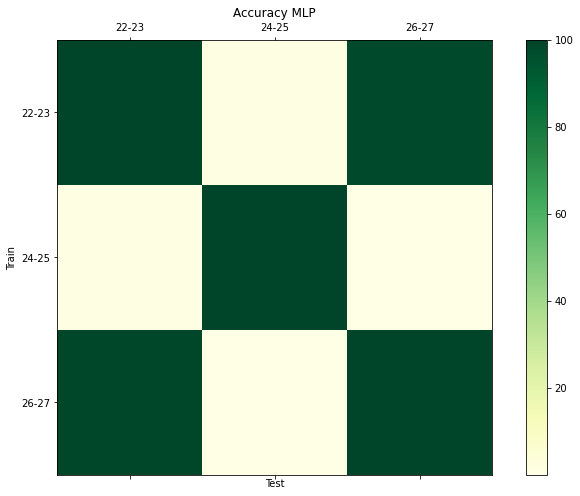

In [51]:
ticks = [f'{i}-{i+1}' for i in range(22, 27, 2)]
fig_mlp, ax_mlp = plot_matshow(df2, [' '] + ticks, [' '] + ticks)
ax_mlp.set_title('Accuracy MLP')
pass

### Try 21-22, 23-24, 25-26, 27-28 data

In [53]:
n_feat = 16
for num in [[i, i+1] for i in range(21, 28, 2)]:
    ckpt = f'mlp_ckpts_really_N_{num[0]}-{num[1]}_16_features'
    CONFIG['ckpt_save_folder'] = ckpt
    X, Y = make_merged_dataset(num, n_feat=n_feat)
    net = dl_models.MlpNeLight(n_feat)
    utils.count_params(net)
    train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
    optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 5e-3))
    utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.62it/s]


Dataset for nums:[21, 22] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 22.99it/s]


Epoch: 1/15, 	 total train loss: 0.18318626573008875


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 254.62it/s]


Epoch: 1/15, 	 total score test: 99.69367341835459, [best score: 99.69367341835459]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.64it/s]


Epoch: 2/15, 	 total train loss: 0.011454095549490903


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 316.19it/s]


Epoch: 2/15, 	 total score test: 99.87496874218554, [best score: 99.87496874218554]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.64it/s]


Epoch: 3/15, 	 total train loss: 0.007026961358684686


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 325.84it/s]


Epoch: 3/15, 	 total score test: 99.93123280820205, [best score: 99.93123280820205]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.86it/s]


Epoch: 4/15, 	 total train loss: 0.005523637740782673


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 317.64it/s]


Epoch: 4/15, 	 total score test: 99.7249312328082, [best score: 99.93123280820205]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 27.20it/s]


Epoch: 5/15, 	 total train loss: 0.005198169597274353


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 324.59it/s]


Epoch: 5/15, 	 total score test: 99.97499374843711, [best score: 99.97499374843711]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.99it/s]


Epoch: 6/15, 	 total train loss: 0.0006645560290874733


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 304.73it/s]


Epoch: 6/15, 	 total score test: 99.99374843710928, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.49it/s]


Epoch: 7/15, 	 total train loss: 0.002366133834584616


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 308.09it/s]


Epoch: 7/15, 	 total score test: 99.93123280820205, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.61it/s]


Epoch: 8/15, 	 total train loss: 0.004500218607943445


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 297.33it/s]


Epoch: 8/15, 	 total score test: 99.96874218554639, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 21.75it/s]


Epoch: 9/15, 	 total train loss: 0.0032695176412216235


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 290.84it/s]


Epoch: 9/15, 	 total score test: 98.99974993748437, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.49it/s]


Epoch: 10/15, 	 total train loss: 0.0022819767560107603


100%|████████████████████████████████████████| 250/250 [00:01<00:00, 247.39it/s]


Epoch: 10/15, 	 total score test: 99.99374843710928, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.88it/s]


Epoch: 11/15, 	 total train loss: 0.0014820043983373552


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 297.61it/s]


Epoch: 11/15, 	 total score test: 99.99374843710928, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.07it/s]


Epoch: 12/15, 	 total train loss: 0.0007806151832835073


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 294.35it/s]


Epoch: 12/15, 	 total score test: 99.99374843710928, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.58it/s]


Epoch: 13/15, 	 total train loss: 0.0001394422137485479


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 275.78it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.38it/s]


Epoch: 14/15, 	 total train loss: 0.00018639143352981678


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 321.37it/s]


Epoch: 14/15, 	 total score test: 99.99374843710928, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.61it/s]


Epoch: 15/15, 	 total train loss: 0.000657388012739595


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 287.10it/s]


Epoch: 15/15, 	 total score test: 99.96249062265566, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.90it/s]


Dataset for nums:[23, 24] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.23it/s]


Epoch: 1/15, 	 total train loss: 0.17770668927339778


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 270.66it/s]


Epoch: 1/15, 	 total score test: 99.73118279569893, [best score: 99.73118279569893]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.73it/s]


Epoch: 2/15, 	 total train loss: 0.008765131757113962


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 326.62it/s]


Epoch: 2/15, 	 total score test: 99.90622655663915, [best score: 99.90622655663915]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 27.17it/s]


Epoch: 3/15, 	 total train loss: 0.004668490728363395


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 336.43it/s]


Epoch: 3/15, 	 total score test: 99.73118279569893, [best score: 99.90622655663915]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.05it/s]


Epoch: 4/15, 	 total train loss: 0.005678754459480725


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 324.30it/s]


Epoch: 4/15, 	 total score test: 99.96874218554639, [best score: 99.96874218554639]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 28.00it/s]


Epoch: 5/15, 	 total train loss: 0.003689770860458544


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 345.57it/s]


Epoch: 5/15, 	 total score test: 99.92498124531133, [best score: 99.96874218554639]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.65it/s]


Epoch: 6/15, 	 total train loss: 0.005420923949361989


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 330.10it/s]


Epoch: 6/15, 	 total score test: 99.53738434608653, [best score: 99.96874218554639]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.58it/s]


Epoch: 7/15, 	 total train loss: 0.004595891449547884


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 309.22it/s]


Epoch: 7/15, 	 total score test: 99.96249062265566, [best score: 99.96874218554639]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.19it/s]


Epoch: 8/15, 	 total train loss: 0.0008107626625485043


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 272.76it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 22.95it/s]


Epoch: 9/15, 	 total train loss: 0.0002167379658907697


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 304.66it/s]


Epoch: 9/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.04it/s]


Epoch: 10/15, 	 total train loss: 0.00012803718797635332


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 331.77it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.51it/s]


Epoch: 11/15, 	 total train loss: 9.119187647992212e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 310.12it/s]


Epoch: 11/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.70it/s]


Epoch: 12/15, 	 total train loss: 9.850638003450924e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 326.13it/s]


Epoch: 12/15, 	 total score test: 99.99374843710928, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 27.13it/s]


Epoch: 13/15, 	 total train loss: 7.930559792340876e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 330.43it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 28.35it/s]


Epoch: 14/15, 	 total train loss: 8.41416369674393e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 333.88it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 27.42it/s]


Epoch: 15/15, 	 total train loss: 4.061743420020174e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 334.53it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.89it/s]


Dataset for nums:[25, 26] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 23.70it/s]


Epoch: 1/15, 	 total train loss: 0.16993175906639907


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 288.38it/s]


Epoch: 1/15, 	 total score test: 99.37484371092773, [best score: 99.37484371092773]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.42it/s]


Epoch: 2/15, 	 total train loss: 0.010783340590405128


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 330.94it/s]


Epoch: 2/15, 	 total score test: 99.9187296824206, [best score: 99.9187296824206]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 27.10it/s]


Epoch: 3/15, 	 total train loss: 0.004184603914543386


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 335.26it/s]


Epoch: 3/15, 	 total score test: 99.96249062265566, [best score: 99.96249062265566]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.03it/s]


Epoch: 4/15, 	 total train loss: 0.00241971293824815


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 329.79it/s]


Epoch: 4/15, 	 total score test: 99.96249062265566, [best score: 99.96249062265566]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.19it/s]


Epoch: 5/15, 	 total train loss: 0.002313168601117908


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 318.38it/s]


Epoch: 5/15, 	 total score test: 99.84371092773193, [best score: 99.96249062265566]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.74it/s]


Epoch: 6/15, 	 total train loss: 0.009459097000334652


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 325.47it/s]


Epoch: 6/15, 	 total score test: 99.46861715428857, [best score: 99.96249062265566]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.87it/s]


Epoch: 7/15, 	 total train loss: 0.006403325905745489


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 307.52it/s]


Epoch: 7/15, 	 total score test: 99.97499374843711, [best score: 99.97499374843711]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.53it/s]


Epoch: 8/15, 	 total train loss: 0.003506530406734636


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 286.51it/s]


Epoch: 8/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.32it/s]


Epoch: 9/15, 	 total train loss: 0.00028981012714681244


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 260.38it/s]


Epoch: 9/15, 	 total score test: 99.98749687421855, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.02it/s]


Epoch: 10/15, 	 total train loss: 0.00030885249584717975


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 314.89it/s]


Epoch: 10/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.06it/s]


Epoch: 11/15, 	 total train loss: 9.539721307397309e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 280.87it/s]


Epoch: 11/15, 	 total score test: 99.99374843710928, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.34it/s]


Epoch: 12/15, 	 total train loss: 7.51529656965079e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 288.54it/s]


Epoch: 12/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.48it/s]


Epoch: 13/15, 	 total train loss: 8.234115108690833e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 277.03it/s]


Epoch: 13/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.78it/s]


Epoch: 14/15, 	 total train loss: 0.00014013300780436934


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 294.74it/s]


Epoch: 14/15, 	 total score test: 100.0, [best score: 100.0]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.26it/s]


Epoch: 15/15, 	 total train loss: 7.272874174832982e-05


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 311.94it/s]


Epoch: 15/15, 	 total score test: 100.0, [best score: 100.0]

[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.95it/s]


Dataset for nums:[27, 28] was created
[INFO]: Model "MlpNeLight" has 144068 trainable parameters


100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 22.73it/s]


Epoch: 1/15, 	 total train loss: 0.17778896474309505


100%|████████████████████████████████████████| 250/250 [00:01<00:00, 224.07it/s]


Epoch: 1/15, 	 total score test: 99.58114528632159, [best score: 99.58114528632159]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.14it/s]


Epoch: 2/15, 	 total train loss: 0.008565942219819033


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 300.90it/s]


Epoch: 2/15, 	 total score test: 99.89372343085772, [best score: 99.89372343085772]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.24it/s]


Epoch: 3/15, 	 total train loss: 0.005605497222859412


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 316.92it/s]


Epoch: 3/15, 	 total score test: 99.84996249062266, [best score: 99.89372343085772]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.08it/s]


Epoch: 4/15, 	 total train loss: 0.006735345509256267


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 310.57it/s]


Epoch: 4/15, 	 total score test: 99.94998749687421, [best score: 99.94998749687421]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.07it/s]


Epoch: 5/15, 	 total train loss: 0.00553920638236788


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 303.59it/s]


Epoch: 5/15, 	 total score test: 99.81870467616905, [best score: 99.94998749687421]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.49it/s]


Epoch: 6/15, 	 total train loss: 0.005106535935474019


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 312.33it/s]


Epoch: 6/15, 	 total score test: 99.84996249062266, [best score: 99.94998749687421]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.91it/s]


Epoch: 7/15, 	 total train loss: 0.0016323689513580663


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 311.51it/s]


Epoch: 7/15, 	 total score test: 99.97499374843711, [best score: 99.97499374843711]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.77it/s]


Epoch: 8/15, 	 total train loss: 0.00034293677256960845


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 309.67it/s]


Epoch: 8/15, 	 total score test: 99.98749687421855, [best score: 99.98749687421855]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.20it/s]


Epoch: 9/15, 	 total train loss: 0.00036761133519429414


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 317.19it/s]


Epoch: 9/15, 	 total score test: 99.99374843710928, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.64it/s]


Epoch: 10/15, 	 total train loss: 0.0012006019237413702


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 314.91it/s]


Epoch: 10/15, 	 total score test: 99.98749687421855, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 26.22it/s]


Epoch: 11/15, 	 total train loss: 0.0046648797202402835


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 302.47it/s]


Epoch: 11/15, 	 total score test: 99.91247811952988, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 24.79it/s]


Epoch: 12/15, 	 total train loss: 0.006065567490652264


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 317.85it/s]


Epoch: 12/15, 	 total score test: 99.97499374843711, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.42it/s]


Epoch: 13/15, 	 total train loss: 0.0008477122264007301


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 315.18it/s]


Epoch: 13/15, 	 total score test: 99.96874218554639, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.62it/s]


Epoch: 14/15, 	 total train loss: 0.001513708778797844


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 315.07it/s]


Epoch: 14/15, 	 total score test: 99.98124531132783, [best score: 99.99374843710928]



100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 25.31it/s]


Epoch: 15/15, 	 total train loss: 0.00035153765571932684


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 306.06it/s]

Epoch: 15/15, 	 total score test: 99.98749687421855, [best score: 99.99374843710928]



In [54]:
model = dl_models.MlpNeLight(in_features=16)
ckpts_paths = [f'mlp_ckpts_really_N_{i}-{i+1}_16_features' for i in range(21, 28, 2)]
df3 = multy_cross_test(model, ckpts_paths, create_test_dataloader2)

mlp_ckpts_really_N_21-22_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.55it/s]


Dataset for nums:[21, 22] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 322.37it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.47it/s]


Dataset for nums:[23, 24] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 312.60it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.70it/s]


Dataset for nums:[25, 26] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 310.19it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.94it/s]


Dataset for nums:[27, 28] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 312.01it/s]


mlp_ckpts_really_N_23-24_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 24.56it/s]


Dataset for nums:[21, 22] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 315.70it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.57it/s]


Dataset for nums:[23, 24] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 277.99it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.05it/s]


Dataset for nums:[25, 26] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 276.33it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.50it/s]


Dataset for nums:[27, 28] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 302.56it/s]


mlp_ckpts_really_N_25-26_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.12it/s]


Dataset for nums:[21, 22] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 308.91it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.17it/s]


Dataset for nums:[23, 24] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 307.86it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 20.54it/s]


Dataset for nums:[25, 26] was created


100%|████████████████████████████████████████| 250/250 [00:01<00:00, 248.26it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.80it/s]


Dataset for nums:[27, 28] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 313.41it/s]


mlp_ckpts_really_N_27-28_16_features
[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.73it/s]


Dataset for nums:[21, 22] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 289.66it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 23.77it/s]


Dataset for nums:[23, 24] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 310.03it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 22.95it/s]


Dataset for nums:[25, 26] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 292.76it/s]


[ Using Seed :  42  ]


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 21.98it/s]


Dataset for nums:[27, 28] was created


100%|████████████████████████████████████████| 250/250 [00:00<00:00, 314.08it/s]


/tmp/ipykernel_23688/1073259438.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels)
/tmp/ipykernel_23688/1073259438.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels)


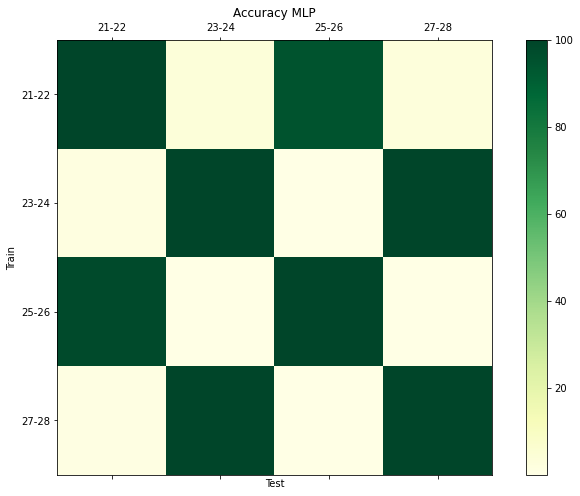

In [56]:
ticks = [f'{i}-{i+1}' for i in range(21, 28, 2)]
fig_mlp, ax_mlp = plot_matshow(df3, [' '] + ticks, [' '] + ticks)
ax_mlp.set_title('Accuracy MLP')
pass